# S&P 500 Replication

Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_theme()

## Read in Data
* All the tickers for S&P 500
* Data File containing daily information for the relevant companies from 2010/12/31-2020/12/31
  * Prices, tickers, dividends, stock splits, and market_cap.

In [2]:
# Get tickers for S&P
ticker_list_all = list(pd.read_csv('spy_ticker.txt',header=None).iloc[:,0]) 

# Read in the stock data and convert date variables to datetime
df = pd.read_csv('stock_data.csv')
# Converting some cols to date time
df['datadate'] = pd.to_datetime(df.datadate)
df = df.set_index(['datadate']) # This makes stuff easier to do later on

In [7]:
df# Let's see what we're working with.

,tic,conm,div,cshoc,prccd,ajexdi,market_cap
datadate,,,,,,,
2010-01-04,A,AGILENT TECHNOLOGIES INC,NaN,348831000.0,31.30,1.0,1.091841e+10
2010-01-05,A,AGILENT TECHNOLOGIES INC,NaN,348831000.0,30.96,1.0,1.079981e+10
2010-01-06,A,AGILENT TECHNOLOGIES INC,NaN,348831000.0,30.85,1.0,1.076144e+10
2010-01-07,A,AGILENT TECHNOLOGIES INC,NaN,348831000.0,30.81,1.0,1.074748e+10
2010-01-08,A,AGILENT TECHNOLOGIES INC,NaN,348831000.0,30.80,1.0,1.074399e+10
...,...,...,...,...,...,...,...
2021-10-01,ZTS,ZOETIS INC,NaN,473944000.0,196.19,1.0,9.298307e+10
2021-10-04,ZTS,ZOETIS INC,NaN,473944000.0,193.69,1.0,9.179821e+10
2021-10-05,ZTS,ZOETIS INC,NaN,473944000.0,196.46,1.0,9.311104e+10


### Set Portfolio Parameters



In [4]:
INITIAL_PORTFOLIO_VALUE = 100_000_000
PORTFOLIO_START_DATE = pd.to_datetime('12-31-2010')
PORTFOLIO_END_DATE = pd.to_datetime('12-31-2020')
# TRANSACTION_COST_PER_TRADE = .001 


#Get the quarter end dates to rebalance and yearly dates for reconstitution
reconstitution_dates = pd.date_range(PORTFOLIO_START_DATE,PORTFOLIO_END_DATE,freq='BY')
rebalance_dates = pd.date_range(PORTFOLIO_START_DATE,PORTFOLIO_END_DATE,freq='BQ')
all_business_dates = pd.date_range(PORTFOLIO_START_DATE,PORTFOLIO_END_DATE,freq='B')

# Make sure to only use business dates that are in our data file
all_business_dates = [date for date in all_business_dates if date in df.index]

### Now, here are a bunch of helper functions that are used when iterating through each date and updating the portfolio:

In [5]:


def get_ticker_indexed_series(date, df:pd.DataFrame):
    """Helper function to filter a df by only the date we want and make the index the tickers for easy lookup"""
    return df.loc[[date]].set_index(['tic']) # # Only look at the date we want


def get_index_weights(ticker_list, date, df:pd.DataFrame):
    """Send in a ticker list, along with date and spit out series with the tickers and their weights"""

    df = get_ticker_indexed_series(date, df)['market_cap'] # Get market caps for all tickers on that date
    df = df[df.index.isin(ticker_list)] # Filter for relevant securities
    weight_series = df/df.sum() # Get their weights

    return weight_series


def get_rebalanced_share_counts(date, portfolio_weights:pd.Series, df:pd.DataFrame , portfolio_value:float):
    """This function is used to calculate the new share counts that the portfolio will have after rebalancing to 
    the specified weights.
    """

    tickers = list(portfolio_weights.index) 

    prices = get_ticker_indexed_series(date, df)['prccd']
    prices = prices[prices.index.isin(tickers)]

    dollars_per_security = port_weights * portfolio_value
    desired_shares = np.floor(dollars_per_security / prices)
    total_value_of_shares = (desired_shares * prices).sum()
    cash_leftover = portfolio_value - total_value_of_shares

    desired_share_counts = get_zeroed_share_counts_series()
    desired_share_counts[desired_shares.index] = desired_shares
    desired_share_counts.loc['PORT_CASH'] = cash_leftover

    return desired_share_counts



def calculate_portfolio_value(price_date, df:pd.DataFrame, share_count_series:pd.Series, previous_wealth:float):
    """Calculate portfolio value based on the date sent in an the share counts you currently have"""
    prices = get_ticker_indexed_series(price_date, df)['prccd']
    value_of_stocks = (share_count_series * prices).sum()
    cash = share_count_series['PORT_CASH'] 
    calculated_wealth = value_of_stocks + cash

    # This is super hacky, I know. But for 3 of the dates, there are no prices and it makes the wealth almost nothing
    # So the below condition will just return the previous day wealth if it is way to small to be realistic
    if calculated_wealth/previous_wealth < .05:
        return previous_wealth
    else:
        return calculated_wealth


def calculate_dividends_received(date, df:pd.DataFrame , share_counts_series:pd.Series):
    """Return amount of cash dividends received on the given date based on the shares in portfolio. Returns the total amount."""
    df = get_ticker_indexed_series(date, df)
    divs_per_stock = df['div'] * share_counts_series
    total_dividends = divs_per_stock.sum()
    return total_dividends


def get_biggest_companies(date, df:pd.DataFrame, number_companies=10):
    """Return a dataframe of the biggest companies by market cap at that time you send in."""
    df = get_ticker_indexed_series(date, df)
    top_companies_df = df.sort_values('market_cap', ascending=False)[:number_companies]
    return top_companies_df

def get_additional_shares_from_div_reinvestment(date, dividend_amount:float, df:pd.DataFrame):
    """Takes in the current share counts at that date and icnreases them as necessary. Invest in 10 biggest stocks by market cap at that date"""
    
    ten_biggest_stocks_df = get_biggest_companies(date, df, number_companies=10)

    weights_to_invest = ten_biggest_stocks_df['market_cap']/ten_biggest_stocks_df['market_cap'].sum() # Invest in proportion of their market caps
    dollars_per_stock = weights_to_invest * dividend_amount 

    shares_to_purchase = np.floor(dollars_per_stock / ten_biggest_stocks_df['prccd'])
    cash_leftover = dividend_amount - (shares_to_purchase * ten_biggest_stocks_df['prccd']).sum()

    # Now put those shares into a series and return it
    additional_shares = get_zeroed_share_counts_series()
    additional_shares[shares_to_purchase.index] = shares_to_purchase 
    additional_shares.loc['PORT_CASH'] = cash_leftover

    return additional_shares


def get_shares_adjusted_for_splits(today, previous_day, df:pd.DataFrame, share_count:pd.Series):
    """This function is used to calculate the new share counts, based on if there were any splits on that day
    You s
    """
    new_share_counts = share_count.copy()
    today_factors = get_ticker_indexed_series(today, df)['ajexdi'].dropna()
    yesterday_factors = get_ticker_indexed_series(previous_day, df)['ajexdi'].dropna()

    if len(today_factors) != len(yesterday_factors): # If the lengths of these dbs are different then there is weird stuff so just send back the originals
        return new_share_counts

    adjustment_factors = yesterday_factors/today_factors # New shares are a multiple of yesterday's factor divided by today
    new_share_counts[adjustment_factors.index] = adjustment_factors * new_share_counts[adjustment_factors.index] # Update the relevant share counts by the factor if returned a value

    return new_share_counts

def get_zeroed_share_counts_series():
    """Helper function to create a series with all the tickers as the index and the values are all zeros"""
    return pd.Series(data=np.zeros(len(ticker_list_all)+1),index=ticker_list_all+ ['PORT_CASH'])



## Now the fun begins:
We loop through all of the dates in the time horizon, for each date, we do several things:
* Calculate any dividends that have been received based on the shares currently held in the portfolio.
* Reinvest those dividends into new shares where the new shares purchased are selected from the top 10 companies by market cap on the date the dividends were received.
* Adjust the shares in the portfolio based on any share splits that took place.
* Calculate the total portfolio value at that date and store it in a series for later reference
* Then, check if the day is a reconsitution date, if it is, then you will now set your the top 250 companies on that day as your new reference list to replicate the S&P
* Finally, if you are on a rebalancing date, you rebalance the shares to match the market cap weighted index of top 250 companies.

## WARNING!!!!!!!!!!
Below cell takes like 15-20 minutes to run. Be wary.

In [ ]:
# Set some intitial parameters for the portfolio which are necessary for the below loop to work properly.
#------------------------------------------------------------------------------------------------------

# Below data frame which will hold share counts for all of the tickers we have + a column to indicate the cash in the portfolio at that date
portfolio_df = pd.DataFrame(data=np.zeros((len(all_business_dates),len(ticker_list_all)+1)),columns=ticker_list_all + ['PORT_CASH'], index=all_business_dates)
all_wealths = pd.Series() # Used to track how wealth changes over time


index_constituents = list(get_biggest_companies(PORTFOLIO_START_DATE, df, number_companies=250).index) # Set initial list
portfolio_weights = get_index_weights(index_constituents, PORTFOLIO_START_DATE,df) # Set initial weights

share_counts = get_zeroed_share_counts_series() # Set initial share counts
share_counts.loc['PORT_CASH'] = INITIAL_PORTFOLIO_VALUE

previous_day = PORTFOLIO_START_DATE
previous_wealth = INITIAL_PORTFOLIO_VALUE
#------------------------------------------------------------------------------------------------------


for day in all_business_dates:

    dividend_dollar_amount = calculate_dividends_received(day, df, share_counts) # Collect the days dividends based on yesterday's shares

    # Below will adjust current share counts based on if there was a share split
    share_counts = get_shares_adjusted_for_splits(day, previous_day, df, share_counts)

    # Reinvest those dividends that were received in the 10 biggest stocks
    if dividend_dollar_amount > 0:
        additional_shares = get_additional_shares_from_div_reinvestment(day, dividend_dollar_amount, df) 
        share_counts = share_counts + additional_shares
    
    # Calculate wealth to store in wealth series, and which may be needed later on for rebalancing
    total_portfolio_value = calculate_portfolio_value(day, df , share_counts, previous_wealth)

    all_wealths.loc[day] = total_portfolio_value # Store the wealth value of portfolio here for later analysis

    if day in reconstitution_dates: # Get new index memebers if necessary.
        # We will use the 250 biggest companies on the day of reconstitution
        index_constituents = list(get_biggest_companies(day, df, number_companies=250).index)
        all_wealths.to_csv('sp_wealths.csv')
        print(f'------Getting reconsitution for S&P for: {day} ----------')
        

    if day in rebalance_dates:
        port_weights = get_index_weights(index_constituents, day, df) # Get new portfolio weights
        share_counts = get_rebalanced_share_counts(day, port_weights, df, total_portfolio_value) # Get new share counts


    portfolio_df.loc[day] = share_counts # Get the updated share counts that we use to calculate tomorrow's portfolio value and dividends
    previous_day = day # Update previous day for next loop
    previous_wealth = total_portfolio_value # Set previous wealth for the next loop
    
    
# portfolio_df.to_csv('sp_portfolio.csv')
# all_wealths.to_csv('sp_wealths.csv')



## Portfolio Returns VS. Index, Mutual Fund, and ETF

First, get all returns into a data frame. The returns for the index, mutual fund and etf are in separate csv files so we have to read those in and do some data wrangling before we can compare them.

In [175]:
returns_df = all_wealths.copy() # This is if you get data from above
returns_df = pd.read_csv('sp_wealths.csv') #Comment this out if you use the above. It's the same data, just from different places

returns_df.columns = ['date', 'wealth']
returns_df.index = pd.to_datetime(returns_df['date'])
returns_df = returns_df.drop(columns='date')
returns_df['Portfolio'] = returns_df.pct_change()
returns_df = returns_df.dropna()

#Index
sp = pd.read_csv('sp500_data.csv')
sp_returns = sp[['caldt','sprtrn']].copy()
sp_returns['date'] = pd.to_datetime(sp['caldt'].astype(str), format='%Y%m%d')
sp_returns.index = sp_returns['date']
sp_returns.drop(columns=['caldt','date'], inplace=True)
sp_returns.columns = ['sp_500_index']

returns_df = returns_df.merge(sp_returns, left_index=True, right_index=True)

# Mutual Fund
mutual = pd.read_csv('mutual_fund.csv')
mutual_returns = mutual[['dret','caldt']].copy()
mutual_returns['date'] = pd.to_datetime(mutual_returns['caldt'].astype(str), format='%Y%m%d')
mutual_returns.index = mutual_returns['date']
mutual_returns.drop(columns=['caldt','date'], inplace=True)
mutual_returns.columns = ['sp_500_mutual']

returns_df = returns_df.merge(mutual_returns, left_index=True, right_index=True)


# ETF
etf = pd.read_csv('VOO_data.csv')
etf = etf[['date','RET']].copy()
etf['date'] = pd.to_datetime(etf['date'].astype(str), format='%Y%m%d')
etf.index = etf['date']
etf.drop(columns=['date'], inplace=True)
etf.columns = ['sp_500_etf']
returns_df = returns_df.merge(etf, left_index=True, right_index=True)
returns_df = returns_df.drop(columns='wealth')

In [177]:
daily_return_mean = returns_df[['Portfolio','sp_500_index','sp_500_mutual', 'sp_500_etf']].mean()
standard_deviation_returns = returns_df[['Portfolio','sp_500_index','sp_500_mutual', 'sp_500_etf']].std()

Annualized returns:


In [178]:
daily_return_mean*252

Portfolio        0.137745
sp_500_index     0.117623
sp_500_mutual    0.118851
sp_500_etf       0.117517
dtype: float64

Annualized Standard Deviation

In [179]:
standard_deviation_returns * np.sqrt(252)

Portfolio        0.165535
sp_500_index     0.167073
sp_500_mutual    0.159978
sp_500_etf       0.166576
dtype: float64

### Tracking Errors:


In [170]:
index_t_error_annualized = (returns_df['Portfolio'] - returns_df['sp_500_index']).std() * np.sqrt(252)
mutual_t_error_annualized = (returns_df['Portfolio'] - returns_df['sp_500_mutual']).std() * np.sqrt(252)
etf_t_error_annualized = (returns_df['Portfolio'] - returns_df['sp_500_etf']).std() * np.sqrt(252)
print(f'Tracking Error for the index is: {index_t_error_annualized}')
print(f'Tracking Error for the mutual fund is: {mutual_t_error_annualized}')
print(f'Tracking Error for the ETF is: {etf_t_error_annualized}')

Tracking Error for the index is: 0.010548857387807269
Tracking Error for the mutual fund is: 0.0292902755393945
Tracking Error for the ETF is: 0.017545739612290567


## Plot Cumulative Returns against each other:

Text(0.5, 1.0, 'Cumulative Return of $1')

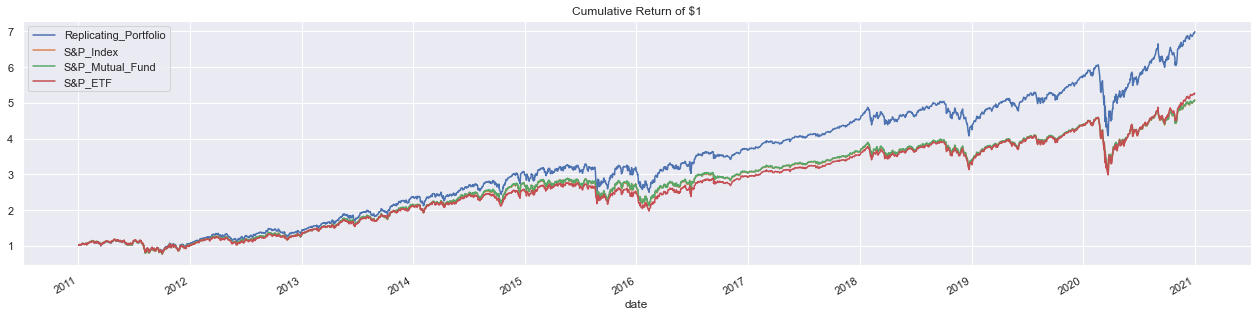

In [187]:
# First, getting cumulative returns
returns_df['Replicating_Portfolio'] = np.cumproduct(returns_df['Portfolio'] + 1)
returns_df['S&P_Index'] = np.cumproduct(returns_df['sp_500_index'] + 1)
returns_df['S&P_Mutual_Fund'] = np.cumproduct(returns_df['sp_500_etf'] + 1)
returns_df['S&P_ETF'] = np.cumproduct(returns_df['sp_500_mutual'] + 1)

returns_df[['Replicating_Portfolio','S&P_Index','S&P_Mutual_Fund','S&P_ETF']].plot(figsize=(22,5))
plt.title('Cumulative Return of $1')
# plt.xlabel('Date')
# plt.ylabel('Return')